# Assignment 2

## Nidhi 

### MDS202222

#### nidhi@cmi.ac.in

# Q1 

### Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time



### Helper functions

In [2]:
def execute_episode(grid_size, target, penalty, obstacles, params, temp, discount):
    state = (0, 0)
    cum_reward = 0
    gamma_power = 1
    path, decisions, rewards = [], [], []

    while state != target:
        path.append(state)
        act_probs = [compute_action_prob(state, a, params, temp) for a in range(4)]
        chosen_act = np.random.choice(4, p=np.array(act_probs))
        
        if chosen_act == 0:
            action = np.random.choice(4, p=[0.8, 0.1, 0.05, 0.05])
        elif chosen_act == 1:
            action = np.random.choice(4, p=[0.1, 0.8, 0.05, 0.05])
        elif chosen_act == 2:
            action = np.random.choice(4, p=[0.05, 0.05, 0.8, 0.1])
        else:
            action = np.random.choice(4, p=[0.05, 0.05, 0.1, 0.8])
        
        decisions.append(action)
        new_state = transition_state(state, action, grid_size, obstacles)
        reward = evaluate_reward(new_state, target, penalty) * gamma_power
        rewards.append(reward)
        cum_reward += reward
        state = new_state
        gamma_power *= discount

    return cum_reward, path, decisions, rewards


In [3]:
def compute_action_prob(state, action, params, temp):
    exp_vals = np.exp(temp * params[state[0], state[1], action])
    sum_exp = np.sum(np.exp(temp * params[state[0], state[1]]))
    return exp_vals / sum_exp

def transition_state(state, action, grid_size, obstacles):
    x, y = state
    if action == 0:
        x = max(0, x - 1)
    elif action == 1:
        x = min(grid_size - 1, x + 1)
    elif action == 2:
        y = max(0, y - 1)
    elif action == 3:
        y = min(grid_size - 1, y + 1)
    return (x, y) if (x, y) not in obstacles else state





In [4]:
def basic_reinforce(grid_size, target, penalty, obstacles, temp, tol, max_eps, trials, discount, learn_rate):
    results = []
    for _ in range(trials):
        params = np.random.rand(grid_size, grid_size, 4)
        gains = []
        for ep in range(max_eps):
            cum_reward, path, decisions, rewards = execute_episode(grid_size, target, penalty, obstacles, params, temp, discount)
            disc_rewards = discount_rewards(rewards, discount)
            params = adjust_params(params, path, decisions, disc_rewards, temp, discount, learn_rate)
            gains.append(cum_reward)
            if ep > 0 and abs(gains[-1] - gains[-2]) < tol:
                break
        results.append(gains)
    avg_gain, err = process_results(results, discount)
    return avg_gain, err

def enhance_reinforce(grid_size, target, penalty, obstacles, temp, tol, max_eps, trials, discount, learn_rate, baseline_weight, lam, value_weight_alpha):
    results = []
    for _ in range(trials):
        params = np.random.rand(grid_size, grid_size, 4)
        baseline_weights = np.random.rand(grid_size, grid_size, 4)
        gains = []
        for ep in range(max_eps):
            cum_reward, path, decisions, rewards = execute_episode(grid_size, target, penalty, obstacles, params, temp, discount)
            disc_rewards = discount_rewards(rewards, discount)
            params, baseline_weights = adjust_baseline_params(params, baseline_weights, path, decisions, disc_rewards, rewards, temp, discount, learn_rate, lam, value_weight_alpha)
            gains.append(cum_reward)
            if ep > 0 and abs(gains[-1] - gains[-2]) < tol:
                break
        results.append(gains)
    avg_gain, err = process_results(results, discount)
    return avg_gain, err



In [5]:
def evaluate_reward(state, target, penalty):
    if state == target:
        return 10
    elif state == penalty:
        return -10
    else:
        return 0
def discount_rewards(rewards, discount):
    disc_rewards = np.zeros_like(rewards)
    total = 0
    for t in reversed(range(len(rewards))):
        total = total * discount + rewards[t]
        disc_rewards[t] = total
    return disc_rewards

In [6]:
def adjust_baseline_params(params, baseline_weights, path, decisions, disc_rewards, rewards, temp, discount, learn_rate, lam, value_weight_alpha):
    grad_params = np.zeros_like(params)
    grad_baseline = np.zeros_like(baseline_weights)
    for t in range(len(path) - 1):
        state = path[t]
        action = decisions[t]
        G_t = disc_rewards[t]
        prob = compute_action_prob(state, action, params, temp)
        perturbed_params = np.copy(params)
        perturbed_params[state[0], state[1], action] += 0.001
        prob_perturbed = compute_action_prob(state, action, perturbed_params, temp)
        grad_log_prob = (np.log(prob_perturbed) - np.log(prob)) / 0.001
        v_w = np.sum(baseline_weights[state[0], state[1]])
        delta = rewards[t] + discount * np.sum(baseline_weights[path[t+1][0], path[t+1][1]]) - v_w
        grad_baseline_state = np.zeros_like(baseline_weights)
        grad_baseline_state[state[0], state[1], action] = 1
        grad_baseline = discount * lam * grad_baseline + grad_baseline_state
        params += learn_rate * (discount ** t) * (G_t - v_w) * grad_log_prob
        baseline_weights += value_weight_alpha * delta * grad_baseline
    return params, baseline_weights

In [7]:
def adjust_params(params, path, decisions, disc_rewards, temp, discount, learn_rate):
    grad_params = np.zeros_like(params)
    for t in range(len(path)):
        state = path[t]
        action = decisions[t]
        G_t = disc_rewards[t]
        prob = compute_action_prob(state, action, params, temp)
        perturbed_params = np.copy(params)
        perturbed_params[state[0], state[1], action] += 0.001
        prob_perturbed = compute_action_prob(state, action, perturbed_params, temp)
        grad_log_prob = (np.log(prob_perturbed) - np.log(prob)) / 0.001
        grad_params[state[0], state[1], action] += (discount ** t) * G_t * grad_log_prob
    params += learn_rate * grad_params
    return params





In [8]:
def process_results(results, discount):
    max_length = max(len(result) for result in results)
    padded_results = np.array([result + [10 * (discount ** k)] * (max_length - len(result)) for k, result in enumerate(results)])
    avg_gain = np.mean(padded_results, axis=0)
    err = np.std(padded_results, axis=0) / np.sqrt(len(results))
    return avg_gain, err



### Hyperparameters

In [9]:
grid_size = 5
goal = (4, 4)
water = (4, 2)
obstacles = [(2, 2), (3, 2)]
sigma = 0.1
epsilon = 0.001
max_episodes = 100
num_trials = 300
gamma = 0.9
alpha = 0.1



###  Timing the execution of a smaller portion


In [10]:
start_time = time.time()

# Run a small portion of the code to estimate time
sample_trials = 10
sample_episodes = 10
basic_reinforce(grid_size, goal, water, obstacles, sigma, epsilon, sample_episodes, sample_trials, gamma, alpha)
enhance_reinforce(grid_size, goal, water, obstacles, sigma, epsilon, sample_episodes, sample_trials, gamma, alpha, 0.1, 0.1, 0.1)

end_time = time.time()
elapsed_time = end_time - start_time



In [11]:
# Estimate total time
estimated_total_time = elapsed_time * (num_trials / sample_trials) * (max_episodes / sample_episodes)
print(f"Estimated total execution time: {estimated_total_time:.2f} seconds")



Estimated total execution time: 633.01 seconds


### Execute algorithms


In [12]:
# Execute algorithms
avg_gain_basic, err_basic = basic_reinforce(grid_size, goal, water, obstacles, sigma, epsilon, max_episodes, num_trials, gamma, alpha)
avg_gain_enhanced, err_enhanced = enhance_reinforce(grid_size, goal, water, obstacles, sigma, epsilon, max_episodes, num_trials, gamma, alpha, 0.1, 0.1, 0.1)



### Plotting results


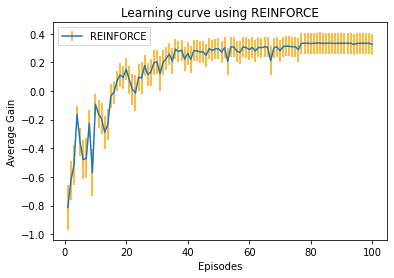

In [13]:
episodes_range = range(1, len(avg_gain_basic) + 1)
plt.errorbar(episodes_range, avg_gain_basic, yerr=err_basic, label='REINFORCE', ecolor='orange')
plt.xlabel('Episodes')
plt.ylabel('Average Gain')
plt.title('Learning curve using REINFORCE')
plt.legend()
plt.show()



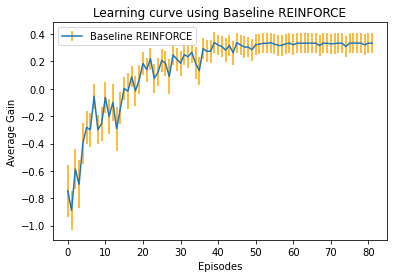

In [14]:
plt.errorbar(range(len(avg_gain_enhanced)), avg_gain_enhanced, yerr=err_enhanced, label='Baseline REINFORCE', ecolor='orange')
plt.xlabel('Episodes')
plt.ylabel('Average Gain')
plt.title('Learning curve using Baseline REINFORCE')
plt.legend()
plt.show()



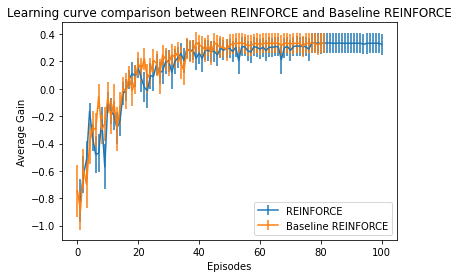

In [15]:
plt.errorbar(episodes_range, avg_gain_basic, yerr=err_basic, label='REINFORCE')
plt.errorbar(range(len(avg_gain_enhanced)), avg_gain_enhanced, yerr=err_enhanced, label='Baseline REINFORCE')
plt.xlabel('Episodes')
plt.ylabel('Average Gain')
plt.title('Learning curve comparison between REINFORCE and Baseline REINFORCE')
plt.legend()
plt.show()

# Q2

In [16]:
def cartpole_dynamics(state, action):
    g = 9.8
    mass_cart = 1.0
    mass_pole = 0.1
    force_magnitude = 10.0
    time_step = 0.001
    pole_length = 1.0
    x, v, theta, theta_dot = state
    force = force_magnitude if action == 1 else -force_magnitude
    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    temp = (force + mass_pole * pole_length * theta_dot**2 * sintheta) / (mass_cart + mass_pole)
    theta_acc = (g * sintheta - costheta * temp) / (pole_length * (4/3 - mass_pole * costheta**2 / (mass_cart + mass_pole)))
    x_acc = temp - mass_pole * pole_length * theta_acc * costheta / (mass_cart + mass_pole)
    
    x += time_step * v
    v += time_step * x_acc
    theta += time_step * theta_dot
    theta_dot += time_step * theta_acc
    
    return (x, v, theta, theta_dot)


In [17]:
def policy(state, params):
    return 1 / (1 + np.exp(-np.dot(params, state)))



def vanilla_reinforce(episodes, learning_rate, policy_params_step, discount_factor):
    params = np.random.rand(4)
    episode_rewards = []
    
    for episode in range(episodes):
        state_sequence, action_sequence, reward_sequence = run_episode(params)
        total_episode_reward = sum(reward_sequence)
        episode_rewards.append(total_episode_reward)
        
        grad_params = np.zeros_like(params)
        for t in range(len(state_sequence)):
            state = np.array(state_sequence[t])
            action = action_sequence[t]
            action_prob = policy(state, params)
            Gt = sum(reward_sequence[t:])
            grad_log_policy = (policy(state, params) - action_prob) * state
            grad_params += (discount_factor ** t) * Gt * grad_log_policy
        
        params += learning_rate * grad_params
        
    return episode_rewards


In [18]:
def value_function(state, value_params):
    return np.dot(state, value_params)

def baseline_reinforce(episodes, learning_rate_theta, learning_rate_value, discount_factor, lambda_factor, policy_params_step, value_params_step):
    policy_params = np.random.rand(4)
    value_params = np.random.rand(4)
    episode_rewards = []
    
    for episode in range(episodes):
        state_sequence, action_sequence, reward_sequence = run_episode(policy_params)
        total_episode_reward = sum(reward_sequence)
        episode_rewards.append(total_episode_reward)
        
        grad_policy_params = np.zeros_like(policy_params)
        eligibility_trace = np.zeros_like(value_params)
        for t in range(len(state_sequence)):
            state = np.array(state_sequence[t])
            action = action_sequence[t]
            action_prob = policy(state, policy_params)
            Gt = sum(reward_sequence[t:])
            grad_log_policy = (policy(state, policy_params) - action_prob) * state
            grad_policy_params += (discount_factor ** t) * Gt * grad_log_policy
            
            grad_value = (value_function(state, value_params + value_params_step) - value_function(state, value_params)) / value_params_step
            eligibility_trace = discount_factor * lambda_factor * eligibility_trace + grad_value
        
        delta = Gt + discount_factor * value_function(state_sequence[-1], value_params) - value_function(state_sequence[0], value_params)
        value_params += learning_rate_value * delta * eligibility_trace
        policy_params += learning_rate_theta * grad_policy_params
    
    return episode_rewards



In [19]:
def run_episode(params):
    state = np.array([0, 0, 0, 0])
    total_reward = 0
    state_sequence = []
    action_sequence = []
    reward_sequence = []
    
    for _ in range(2000):
        state_sequence.append(state)
        action_prob = policy(state, params)
        action = 1 if np.random.rand() < action_prob else 0
        action_sequence.append(action)
        new_state = cartpole_dynamics(state, action)
        if abs(new_state[2]) > 5 * np.pi / 12 or abs(new_state[0]) > 3:
            break
        reward_sequence.append(np.cos(new_state[2]))
        state = new_state
        total_reward += 1
    
    return state_sequence, action_sequence, reward_sequence


In [20]:
def plot_individual_rewards(reinforce_rewards, baseline_rewards):
    episodes = range(1, len(reinforce_rewards) + 1)
    mean_reinforce = np.mean(reinforce_rewards)
    std_reinforce = np.std(reinforce_rewards)
    plt.errorbar(episodes, reinforce_rewards, yerr=std_reinforce, label='REINFORCE', ecolor='orange')
    plt.xlabel('Episodes')
    plt.ylabel('Gain')
    plt.title('REINFORCE Algorithm')
    plt.legend()
    plt.show()

    episodes = range(1, len(baseline_rewards) + 1)
    mean_baseline = np.mean(baseline_rewards)
    std_baseline = np.std(baseline_rewards)
    plt.errorbar(episodes, baseline_rewards, yerr=std_baseline, label='Baseline REINFORCE', ecolor='orange')
    plt.xlabel('Episodes')
    plt.ylabel('Gain')
    plt.title('Baseline REINFORCE Algorithm')
    plt.legend()
    plt.show()

def plot_comparison_rewards(reinforce_rewards, baseline_rewards):
    episodes_reinforce = range(1, len(reinforce_rewards) + 1)
    mean_reinforce = np.mean(reinforce_rewards)
    std_reinforce = np.std(reinforce_rewards)
    episodes_baseline = range(1, len(baseline_rewards) + 1)
    mean_baseline = np.mean(baseline_rewards)
    std_baseline = np.std(baseline_rewards)
    plt.errorbar(episodes_reinforce, reinforce_rewards, yerr=std_reinforce, label='REINFORCE')
    plt.errorbar(episodes_baseline, baseline_rewards, yerr=std_baseline, label='Baseline REINFORCE')
    plt.xlabel('Episodes')
    plt.ylabel('Gain')
    plt.title('Comparison of REINFORCE and Baseline REINFORCE Algorithms')
    plt.legend()
    plt.show()



### Hyperparameters


In [21]:
num_episodes = 1000
alpha = 0.1
beta = 0.1
gamma = 0.9
lambda_factor = 0.9
delta_theta = 0.001
delta_value_params = 0.001



### Execute REINFORCE algorithm


In [22]:
reinforce_results = vanilla_reinforce(num_episodes, alpha, delta_theta, gamma)

### Execute Baseline REINFORCE algorithm


In [ ]:
baseline_results = baseline_reinforce(num_episodes, alpha, beta, gamma, lambda_factor, delta_theta, delta_value_params)

### Plot results


In [ ]:
# Plot results
plot_individual_rewards(reinforce_results, baseline_results)
plot_comparison_rewards(reinforce_results, baseline_results)


## Q1

### Policy Representation - Softmax
The policy for choosing action $( a $) in state $( s $) is given by:
$[ 
\pi(s, a) = \frac{e^{\sigma \cdot \theta_{s_1, s_2, a}}}{\sum_{a'} e^{\sigma \cdot \theta_{s_1, s_2, a'}}} 
$]

### Hyperparameters
- **σ = 0.1**: Controls exploration versus stability. Higher values increase exploration but reduce stability.
- **ϵ = 0.001**: Learning rate. Higher values slow down learning, while lower values increase training time.
- **maxep = 100**: Maximum number of episodes. More episodes lead to better learning but require more computation.
- **numtrails = 300**: Number of trials. More trials improve learning but increase computation time.
- **γ = 0.9**: Discount factor for future rewards. Higher values make the agent consider future rewards more heavily.
- **α, β, λ, vwα = 0.1**: Learning rates for the baseline reinforce algorithm.

## Q2

### Policy Representation - Sigmoid
The policy for choosing action $( a $) in state $( s $) is given by:
$[ 
\pi(s, a) = \frac{1}{1 + e^{-\sum_{t=1}^{4} t_i \cdot s_i}} 
$]

### Cart-Pole Problem Parameters
- **g = 9.8**: Acceleration due to gravity (m/s²).
- **mc = 1**: Mass of the cart (kg).
- **mp = 0.1**: Mass of the pole (kg).
- **F = 10**: Initial force applied (N).
- **dt = 0.001**: Time interval for derivative approximation (s).

### Learning Hyperparameters
- **num_episodes = 100**: Number of episodes. More episodes enhance learning but require more computation time.
- **γ, λ = 0.9**: Discount factor for future rewards. Higher values make the agent prioritize future rewards.
- **α, β = 0.1**: Learning rates. Higher rates speed up learning but may decrease accuracy.
- **delta_theta, delta_w = 0.001**: Step sizes for derivative approximations. Smaller values lead to more accurate approximations but increase running time.
